In [1]:
from __future__ import print_function
from pylab import *
from clampy.analysis.electrode_compensation import *
from clampy import *
from scipy import optimize
from clampy.setup.units import *
from clampy.analysis.cell_analysis import *
import numpy as np
from clampy.analysis.spike_analysis import lowpass

/home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/clampy-0.1-py3.7.egg/clampy/devices/__init__.py:11: UserWarning: Failed to import the Axoclamp 900A module
  warn('Failed to import the Axoclamp 900A module')


In [2]:
import os

In [6]:
cwd=os.getcwd()
cwd

'/home/alteska/Desktop/brian/brian_dev/real_data'

In [9]:
path=cwd + '/'
full=True
filtering=1*ms

In [10]:
print('Analysis')
cmap = cm.bwr

# *** Loading ***
# Parameters
info = load_info(path+'current_pulses.info')
dt, ntrials, long_kernel_size = info['dt'], info['ntrials'], info['kernel_size']
pulse_start, pulse_duration = info['pulse_start'], info['pulse_duration']

Analysis


In [11]:
# Load AEC calibration
signals = np.load(path+'/AEC.npz')
V1_noise, V2_noise = signals['V1'], signals['V2']
try: # Test if it is a two_electrode experiment (inject through Ic2, read on V1) or not
    I_noise = signals['Ic']
except KeyError:
    I_noise = signals['Ic2']

In [12]:
# Kernel calculation
kernel_size = int(5 * ms / dt)
ekernel_size = int(.5 * ms / dt)
# Determine injecting electrode
K1 = full_kernel(V1_noise / volt, I_noise / amp, kernel_size)
K2 = full_kernel(V2_noise / volt, I_noise / amp, kernel_size)
R1, R2 = sum(K1), sum(K2)
if R1>R2:
    injecting_electrode = 'V1'
    recording_electrode = 'V2'
    K = K1
else:
    injecting_electrode = 'V2'
    recording_electrode = 'V1'
    K = K2
    V1_noise, V2_noise = V2_noise, V1_noise
    R1, R2 = R2, R1
if R2>5e6: # if more than 5 MOhm, then we assume there actually is an electrode
    two_electrodes = True
else:
    two_electrodes = False

In [13]:
two_electrodes

False

In [14]:
Ke = electrode_kernel_soma(K, ekernel_size) # 15 time steps
print("Electrode resistance = ",float(sum(Ke)/Mohm),"Mohm")

# Load pulse experiment
amplitudes = loadtxt(path + '/Pulses/amplitudes.txt')
V, V2, Ic, Vraw = [], [], [], []
for i in range(ntrials):
    signals = np.load(path+'/Pulses/pulses{}.npz'.format(i))
    if i==0:
        t = signals['t']
    Vraw.append(signals[injecting_electrode])
    V2.append(signals[recording_electrode])
    try:
        Ic.append(signals['Ic'])
    except KeyError:
        Ic.append(signals['Ic2'])
    V.append(AEC_compensate(Vraw[i], Ic[i], Ke))

V, V2, Ic, Vraw = array(V), array(V2), array(Ic), array(Vraw)
Imin = min(mean(Ic, axis=1))
Imax = max(mean(Ic, axis=1))

Electrode resistance =  13.907401133440162 Mohm


In [15]:
np.shape(Ic)

(40, 22400)

In [16]:
def get_color(I): # assign a color to a current trace
    Imean = mean(I)
    if Imean > 0:
        x = 0.5 + 0.5 * Imean / Imax
    else:
        x = 0.5 - 0.5 * Imean / Imin
    return cmap(x)

In [17]:
# *** Analysis ***
# Cell resistance and capacitance from noise analysis
if two_electrodes:
    Rm, Cm, V0 = passive_properties_from_noise(I_noise, V2_noise, long_kernel_size * dt, dt)
    Rm2, Cm2, V02 = exponential_fit_to_noise(I_noise, V2_noise, kernel_duration=long_kernel_size * dt, dt=dt, R0=50e6, C0=300e-12)
else:
    V_AEC = AEC_compensate(V1_noise, I_noise, Ke)
    Rm, Cm, V0 = passive_properties_from_noise(I_noise, V_AEC, long_kernel_size*dt, dt)
    Rm2, Cm2, V02 = exponential_fit_to_noise(I_noise, V_AEC, kernel_duration=long_kernel_size * dt, dt=dt, R0=50e6, C0=300e-12)

print("Membrane time constant = {} ms or {} ms (exp. fit)".format(Rm*Cm/ ms,Rm2*Cm2/ms))
print("Membrane resistance = {} Mohm or {} Mohm (exp. fit)".format(Rm/Mohm, Rm2/Mohm))
print("Membrane capacitance = {} pF or {} pF (exp. fit)".format(Cm/pF,Cm2/pF))
print("V0 = {} or {} (exp. fit)".format(V0/mV,V02/mV))

Membrane time constant = 17.076740385792082 ms or 18.619596600344394 ms (exp. fit)
Membrane resistance = 166.00424142806145 Mohm or 142.5594620441128 Mohm (exp. fit)
Membrane capacitance = 102.86930164487603 pF or 130.6093354545828 pF (exp. fit)
V0 = -18.65574375433671 or -18.65574375433671 (exp. fit)


Text(0.5, 1.0, 'Membrane kernel')

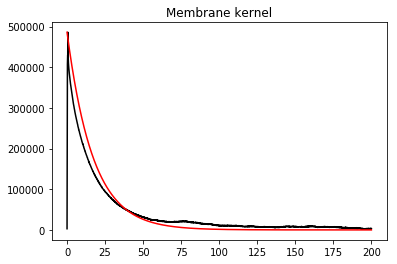

In [18]:
if abs(log(Rm/Rm2))>0.2: # 20% difference in Rm estimated from integral and fit
    print("The linear response of the cell might be oscillatory.")

figure()
if two_electrodes:
    Km, V0 = full_kernel(V2_noise, I_noise, long_kernel_size, full_output=True)
else:
    Km, V0 = full_kernel(V_AEC, I_noise, long_kernel_size, full_output=True)
tk = arange(len(Km))*dt
fit = exp(-tk/(Rm*Cm))*dt/Cm
plot(tk/ms,Km,'k')
plot(tk/ms,fit,'r')
title("Membrane kernel")

In [19]:
V0

-0.018655743754336714

In [20]:
# Subtract offset between the two headstages
if two_electrodes:
    delta_V = mean(V2[:,:int(pulse_start/dt)]) - mean(V[:,:int(pulse_start/dt)])
    V2 = [v2-delta_V for v2 in V2]
    print("Offset between the two traces = {} mV".format(delta_V/mV))

In [21]:
# Calculate initial potential before the pulse
Vstart=mean(V[:,:int(pulse_start / dt)], axis=1)

Text(0.5, 1.0, 'Electrode kernel')

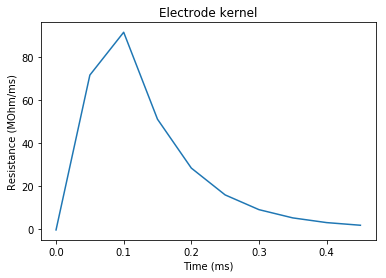

In [22]:
# *** Plotting ***
figure()
plot(arange(len(Ke))*dt/ms,Ke/dt*1e-9)
xlabel('Time (ms)')
ylabel('Resistance (MOhm/ms)')
title("Electrode kernel")

Text(0.5, 1.0, 'Initial potential')

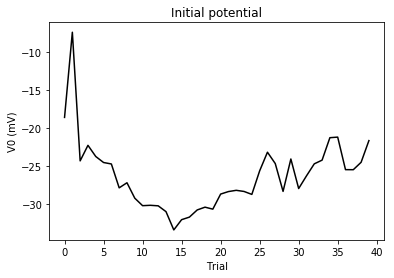

In [23]:
figure()
plot(Vstart/mV,'k')
xlabel('Trial')
ylabel('V0 (mV)')
title("Initial potential")

Text(0.5, 1.0, 'Responses to pulses')

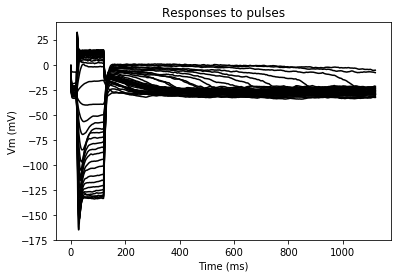

In [24]:
figure()
for Vi,V2i in zip(V,V2):
    plot(t/ms, lowpass(array(Vi) / mV, filtering, dt=dt), 'k')
    if two_electrodes:
        plot(t / ms, lowpass(array(V2i) / mV, filtering, dt=dt), 'r')
xlabel('Time (ms)')
ylabel('Vm (mV)')
title('Responses to pulses')

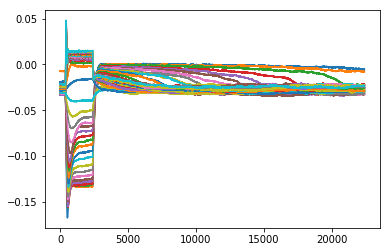

In [25]:
plot(V.transpose());

In [26]:
np.shape(V[0])

(22400,)

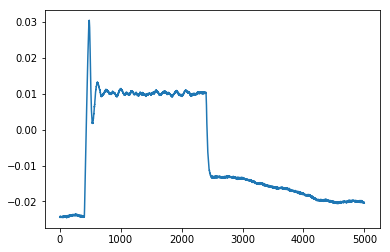

In [27]:
plt.plot(V[29][0:5000])

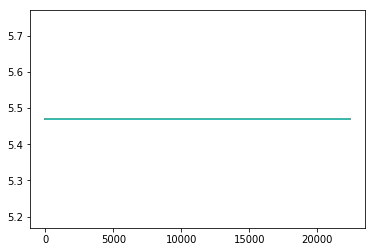

In [28]:
plot(V2.transpose());

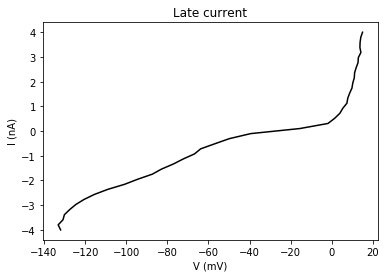

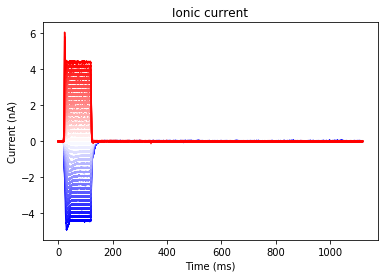

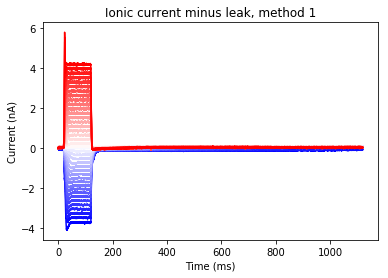

In [29]:
if full:
    # Do the two electrodes match?
    if two_electrodes:
        figure()
        subplot(211)
        for Vi,V2i,Ici in zip(V,V2,Ic):
            plot(t/ms,lowpass((V2i-Vi) / mV, filtering, dt=dt), color=get_color(Ici))
        ylabel('V2-V1 (mV)')
        xlim(min(t / ms), max(t / ms))
        title('Difference between electrode responses')
        subplot(212)
        for Vi,V2i,Ici in zip(V,V2,Ic):
            ind = abs(Ici)>0.1*nA
            color = get_color(Ici)
            Vi, V2i, Ici = Vi[ind], V2i[ind], Ici[ind]
            plot(t[ind]/ms,lowpass((V2i-Vi) / Ici /Mohm, filtering, dt=dt), color=color)
        xlabel('Time (ms)')
        ylabel('Resistance error (MOhm)')
        xlim(min(t / ms), max(t / ms))

    # Late current (at the end of the pulse)
    if two_electrodes:
        V_late=array([Vi[int((pulse_start+pulse_duration-1*ms)/dt)] for Vi in V2])
    else:
        V_late=array([Vi[int((pulse_start+pulse_duration-1*ms)/dt)] for Vi in V])
    figure()
    plot(V_late/mV,amplitudes/nA,'k')
    ylabel('I (nA)')
    xlabel('V (mV)')
    title('Late current')

    figure()
    # Ionic current
    # Current-based AEC
    # We find the best linear predictor of dV_noise/dt from I_noise.
    # This decomposes into membrane current and electrode current.
    # We get the electrode contribution (roughly 1/C).
    # Then we subtract the electrode contribution from subsequent recordings.
    # (We accommodate for some delay)
    if two_electrodes:
        V_noise = V2_noise
        Vpulses = V2
        Vtrue = V2
    else:
        V_noise = V1_noise
        Vpulses = Vraw
        Vtrue = V # AEC compensated
    K = full_kernel(diff(V_noise), I_noise[1:], kernel_size)
    # Electrode kernel calculation
    Ke = electrode_kernel_soma(K, ekernel_size)

    for Vi,Ici in zip(Vpulses,Ic):
        dV = AEC_compensate(diff(Vi), Ici[1:], Ke)
        Iionic = Cm * dV*volt/dt
        plot(t[:-1]/ms, lowpass(-Iionic / nA, filtering, dt=dt),color=get_color(Ici)) # with the convention: inward <0
    xlabel('Time (ms)')
    ylabel('Current (nA)')
    title('Ionic current')

    # Ionic current with leak subtraction
    figure()
    n = len(Ic)*0
    for Vi,V_AEC,Ici in zip(Vpulses[int(n/2):],Vtrue[int(n/2):],Ic[int(n/2):]):
        dV = AEC_compensate(diff(Vi), Ici[1:], Ke)
        Iionic = - (V0-V_AEC[:-1])*volt/Rm + Cm * dV*volt/dt
        plot(t[:-1] / ms, lowpass(-Iionic / nA, filtering, dt=dt), color=get_color(Ici))  # with the convention: inward <0
    xlabel('Time (ms)')
    ylabel('Current (nA)')
    title('Ionic current minus leak, method 1')

    if two_electrodes:
        # Calculated by current-based AEC
        # (problem: the kernel is too noisy)
        figure()
        p = 10
        KI, I0 = full_kernel(I_noise[:-p] / amp, V_noise[p:], 30, full_output=True)
        # Fixing the resistance
        g = sum(KI)
        print("Resistance from current kernel = {} Mohm".format(1 / g / Mohm))
        if False:
            KI+= (1/Rm2 - g)/len(KI) # Fixed from exponential fit
        xlabel('Time (ms)')
        plot(KI)
        title('Current kernel')

        figure()
        n = len(Ic)*0
        for Vi,V_AEC,Ici in zip(Vpulses[int(n/2):],Vtrue[int(n/2):],Ic[int(n/2):]):
            #dV = AEC_compensate(diff(Vi), Ici[1:], Ke)
            #Iionic = - (V0-V_AEC[:-1])*volt/Rm + Cm * dV*volt/dt
            Iionic = -AEC_compensate(Ici[:-p], V_AEC[p:]-V0, KI)
            #plot(t[:-1] / ms, lowpass(-Iionic / nA, filtering, dt=dt))  # with the convention: inward <0
            plot(t[:-p]/ms, lowpass(-Iionic / nA, filtering, dt=dt), color=get_color(Ici)) # with the convention: inward <0
        xlabel('Time (ms)')
        ylabel('Current (nA)')
        title('Ionic current minus leak, method 2')

show()

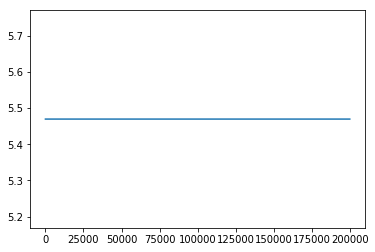

In [31]:
plot(V2_noise)

In [56]:
print(V2_noise.max())
print(V2_noise.min())

5.469613403202441
5.469613403202441


In [57]:
print(V1_noise.max())
print(V1_noise.min())

0.003482982931257135
-0.03964498596366563


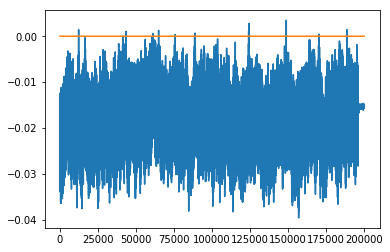

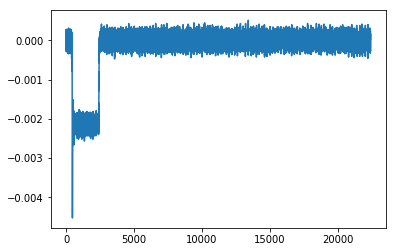

In [63]:
plot(dV);

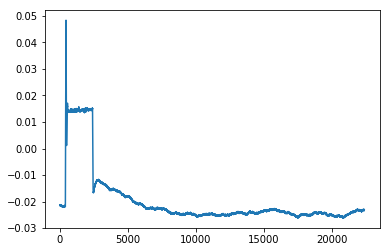

In [35]:
plot(V_AEC)

In [32]:
V0

-0.018655743754336714

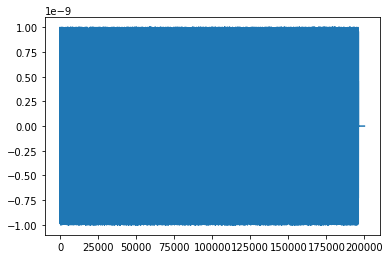

In [37]:
plot(I_noise)

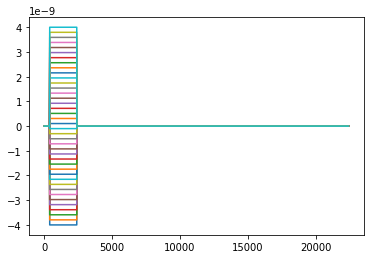

In [111]:
plot(Ic.transpose());

In [112]:
dt

5e-05

## Look at just positive pulses

In [51]:
Ic_positive = Ic[20:]
V_positive = V[20:]

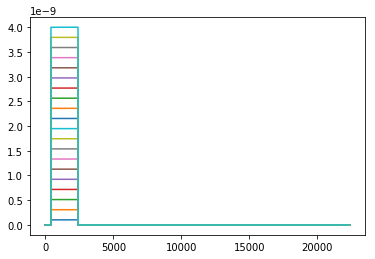

In [49]:
plot(Ic_positive.transpose());

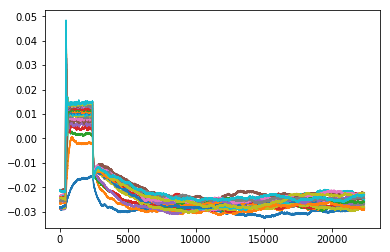

In [53]:
plot(V_positive.transpose());

In [81]:
np.shape(V_positive[0])

(22400,)

## White Noise response and normalization

In [84]:
np.shape(V1_noise[:22400])

(22400,)

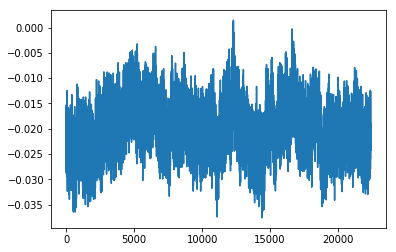

In [83]:
plot(V1_noise[:22400]);

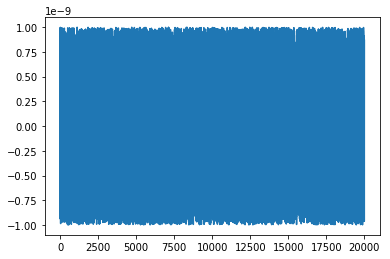

In [68]:
plot(I_noise[:22400]);

In [77]:
V_white_noise_AEC = AEC_compensate(V1_noise, I_noise, Ke)
V_white_noise_AEC

array([-0.02141993, -0.02117839, -0.01818577, ..., -0.01520251,
       -0.01543279, -0.01544924])

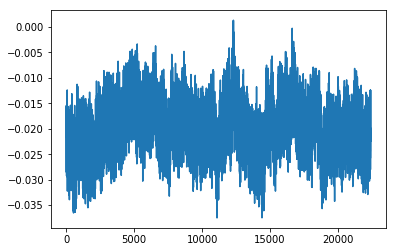

In [85]:
plot(V_white_noise_AEC[:22400]);

In [88]:
V_wnAEC = V_white_noise_AEC[:22400]
I_noise_cut= I_noise[:22400]

## Collect the data to be saved

In [92]:
V_wnAEC

array([-0.02141993, -0.02117839, -0.01818577, ..., -0.01977393,
       -0.020228  , -0.0224099 ])

In [93]:
I_noise_cut

array([ 8.38889762e-10,  5.23898424e-10, -4.74746939e-11, ...,
       -7.04657100e-10, -2.59915410e-10, -9.53343744e-10])

In [94]:
Ic_positive 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
V_positive 

array([[-0.02864093, -0.02855869, -0.02865738, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02885476, -0.02873963, -0.02862449, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02819682, -0.02829552, -0.02832841, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02579534, -0.02564731, -0.02572955, ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02441367, -0.02439722, -0.02418339, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.021272  , -0.02135425, -0.02138714, ..., -0.02329517,
        -0.02314713, -0.02311424]])

## Save the data

In [96]:
import pandas as pd

In [102]:
df_v = pd.DataFrame(V_positive)
df_v.head()

,0,1,2,3,4,5,6,7,8,9,...,22390,22391,22392,22393,22394,22395,22396,22397,22398,22399
0,-0.028641,-0.028559,-0.028657,-0.028789,-0.028411,-0.028575,-0.028493,-0.028493,-0.028427,-0.028592,...,-0.028838,-0.028789,-0.028805,-0.028921,-0.028690,-0.028608,-0.028559,-0.028674,-0.028624,-0.028657
1,-0.028855,-0.028740,-0.028624,-0.028740,-0.028756,-0.028789,-0.028707,-0.028838,-0.028624,-0.028641,...,-0.025927,-0.026272,-0.026174,-0.026075,-0.026157,-0.026338,-0.026157,-0.026091,-0.026322,-0.026026
2,-0.028197,-0.028296,-0.028328,-0.028032,-0.028263,-0.028164,-0.028065,-0.028032,-0.028246,-0.028213,...,-0.028460,-0.028361,-0.028328,-0.028444,-0.028312,-0.028197,-0.028559,-0.028296,-0.028279,-0.028444
3,-0.028378,-0.028246,-0.028230,-0.028378,-0.028427,-0.028345,-0.028378,-0.028509,-0.028263,-0.028197,...,-0.027901,-0.027868,-0.027967,-0.027983,-0.027999,-0.027868,-0.028016,-0.027835,-0.027819,-0.027934
4,-0.028394,-0.028378,-0.028592,-0.028476,-0.028624,-0.028756,-0.028575,-0.028592,-0.028476,-0.028444,...,-0.026667,-0.026716,-0.026897,-0.026733,-0.026782,-0.026864,-0.026716,-0.026634,-0.026667,-0.026651


In [103]:
df_ic = pd.DataFrame(Ic_positive)
df_ic.head()

,0,1,2,3,4,5,6,7,8,9,...,22390,22391,22392,22393,22394,22395,22396,22397,22398,22399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
df_wn_v = pd.DataFrame(V_wnAEC)
df_wn_v.head()

,0
0,-0.021420
1,-0.021178
2,-0.018186
3,-0.015442
4,-0.016491


In [104]:
df_inoise = pd.DataFrame(I_noise_cut)
df_inoise.head()

,0
0,8.388898e-10
1,5.238984e-10
2,-4.747469e-11
3,-5.219016e-10
4,8.112779e-10


In [107]:
df_v.to_csv('decilliated_v_pos.csv')
df_ic.to_csv('decilliated_ic_pos.csv')
df_inoise.to_csv('decilliated_i_noise.csv')
df_wn_v.to_csv('decilliated_v_noise.csv')

## Test data Loading

In [110]:
pd.read_csv('decilliated_v_pos.csv')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,22390,22391,22392,22393,22394,22395,22396,22397,22398,22399
0,0,-0.028641,-0.028559,-0.028657,-0.028789,-0.028411,-0.028575,-0.028493,-0.028493,-0.028427,...,-0.028838,-0.028789,-0.028805,-0.028921,-0.028690,-0.028608,-0.028559,-0.028674,-0.028624,-0.028657
1,1,-0.028855,-0.028740,-0.028624,-0.028740,-0.028756,-0.028789,-0.028707,-0.028838,-0.028624,...,-0.025927,-0.026272,-0.026174,-0.026075,-0.026157,-0.026338,-0.026157,-0.026091,-0.026322,-0.026026
2,2,-0.028197,-0.028296,-0.028328,-0.028032,-0.028263,-0.028164,-0.028065,-0.028032,-0.028246,...,-0.028460,-0.028361,-0.028328,-0.028444,-0.028312,-0.028197,-0.028559,-0.028296,-0.028279,-0.028444
3,3,-0.028378,-0.028246,-0.028230,-0.028378,-0.028427,-0.028345,-0.028378,-0.028509,-0.028263,...,-0.027901,-0.027868,-0.027967,-0.027983,-0.027999,-0.027868,-0.028016,-0.027835,-0.027819,-0.027934
4,4,-0.028394,-0.028378,-0.028592,-0.028476,-0.028624,-0.028756,-0.028575,-0.028592,-0.028476,...,-0.026667,-0.026716,-0.026897,-0.026733,-0.026782,-0.026864,-0.026716,-0.026634,-0.026667,-0.026651
5,5,-0.026141,-0.025993,-0.026009,-0.026124,-0.026009,-0.025976,-0.026108,-0.026042,-0.025943,...,-0.025055,-0.025022,-0.024759,-0.024891,-0.024858,-0.024858,-0.024891,-0.025072,-0.025039,-0.024858
6,6,-0.023673,-0.023542,-0.023673,-0.023706,-0.023443,-0.023624,-0.023641,-0.023542,-0.023608,...,-0.024726,-0.024512,-0.024595,-0.024743,-0.024644,-0.024627,-0.024726,-0.024776,-0.024562,-0.024595
7,7,-0.024891,-0.024841,-0.024940,-0.024858,-0.024858,-0.025022,-0.024956,-0.024989,-0.024924,...,-0.026782,-0.026733,-0.026947,-0.027013,-0.027062,-0.026914,-0.027045,-0.026832,-0.026766,-0.026815
8,8,-0.028444,-0.028098,-0.028147,-0.028131,-0.027967,-0.028082,-0.028378,-0.028378,-0.028230,...,-0.027999,-0.027999,-0.027917,-0.027983,-0.027786,-0.027999,-0.028180,-0.028016,-0.028164,-0.028131
9,9,-0.024479,-0.024496,-0.024315,-0.024282,-0.024266,-0.024282,-0.024101,-0.024381,-0.024397,...,-0.025368,-0.025253,-0.025236,-0.025088,-0.025302,-0.025137,-0.025137,-0.025318,-0.025285,-0.025351
